In [1]:
# !unzip /content/images_background_small1.zip
!unzip /content/images_background.zip

!unzip /content/images_evaluation.zip

Streaming output truncated to the last 5000 lines.
  inflating: images_evaluation/Mongolian/character28/1386_05.png  
  inflating: images_evaluation/Mongolian/character28/1386_06.png  
  inflating: images_evaluation/Mongolian/character28/1386_07.png  
  inflating: images_evaluation/Mongolian/character28/1386_08.png  
  inflating: images_evaluation/Mongolian/character28/1386_09.png  
  inflating: images_evaluation/Mongolian/character28/1386_10.png  
  inflating: images_evaluation/Mongolian/character28/1386_11.png  
  inflating: images_evaluation/Mongolian/character28/1386_12.png  
  inflating: images_evaluation/Mongolian/character28/1386_13.png  
  inflating: images_evaluation/Mongolian/character28/1386_14.png  
  inflating: images_evaluation/Mongolian/character28/1386_15.png  
  inflating: images_evaluation/Mongolian/character28/1386_16.png  
  inflating: images_evaluation/Mongolian/character28/1386_17.png  
  inflating: images_evaluation/Mongolian/character28/1386_18.png  
  inflating

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
import os
from numpy.random import choice as npc
import numpy as np
import time
import random
import torchvision.datasets as dset
from PIL import Image


class OmniglotTrain(Dataset):

    def __init__(self, dataPath, transform=None):
        super(OmniglotTrain, self).__init__()
        np.random.seed(0)
        # self.dataset = dataset
        self.transform = transform
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading training dataset to memory")
        datas = {}
        agrees = [0, 90, 180, 270]
        idx = 0
        for agree in agrees:
            for alphaPath in os.listdir(dataPath):
                for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                    datas[idx] = []
                    for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                        filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                        datas[idx].append(Image.open(filePath).rotate(agree).convert('L'))
                    idx += 1
        print("finish loading training dataset to memory")
        return datas, idx

    def __len__(self):
        return  21000000

    def __getitem__(self, index):
        # image1 = random.choice(self.dataset.imgs)
        label = None
        img1 = None
        img2 = None
        # get image from same class
        if index % 2 == 1:
            label = 1.0
            idx1 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx1])
        # get image from different class
        else:
            label = 0.0
            idx1 = random.randint(0, self.num_classes - 1)
            idx2 = random.randint(0, self.num_classes - 1)
            while idx1 == idx2:
                idx2 = random.randint(0, self.num_classes - 1)
            image1 = random.choice(self.datas[idx1])
            image2 = random.choice(self.datas[idx2])

        if self.transform:
            image1 = self.transform(image1)
            image2 = self.transform(image2)
        return image1, image2, torch.from_numpy(np.array([label], dtype=np.float32))


class OmniglotTest(Dataset):

    def __init__(self, dataPath, transform=None, times=200, way=20):
        np.random.seed(1)
        super(OmniglotTest, self).__init__()
        self.transform = transform
        self.times = times
        self.way = way
        self.img1 = None
        self.c1 = None
        self.datas, self.num_classes = self.loadToMem(dataPath)

    def loadToMem(self, dataPath):
        print("begin loading test dataset to memory")
        datas = {}
        idx = 0
        for alphaPath in os.listdir(dataPath):
            for charPath in os.listdir(os.path.join(dataPath, alphaPath)):
                datas[idx] = []
                for samplePath in os.listdir(os.path.join(dataPath, alphaPath, charPath)):
                    filePath = os.path.join(dataPath, alphaPath, charPath, samplePath)
                    datas[idx].append(Image.open(filePath).convert('L'))
                idx += 1
        print("finish loading test dataset to memory")
        return datas, idx

    def __len__(self):
        return self.times * self.way

    def __getitem__(self, index):
        idx = index % self.way
        label = None
        # generate image pair from same class
        if idx == 0:
            self.c1 = random.randint(0, self.num_classes - 1)
            self.img1 = random.choice(self.datas[self.c1])
            img2 = random.choice(self.datas[self.c1])
        # generate image pair from different class
        else:
            c2 = random.randint(0, self.num_classes - 1)
            while self.c1 == c2:
                c2 = random.randint(0, self.num_classes - 1)
            img2 = random.choice(self.datas[c2])

        if self.transform:
            img1 = self.transform(self.img1)
            img2 = self.transform(img2)
        return img1, img2


# test
if __name__=='__main__':
    omniglotTrain = OmniglotTrain('./images_background', 30000*8)
    print(omniglotTrain)


begin loading training dataset to memory
finish loading training dataset to memory


In [3]:
# cuda.is_available()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')


Using device: cuda

NVIDIA A100-SXM4-40GB
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Siamese(nn.Module):

    def __init__(self):
        super(Siamese, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 10),  # 64@96*96
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),  # 64@48*48
            nn.Conv2d(64, 128, 7),
            nn.ReLU(),    # 128@42*42
            nn.MaxPool2d(2),   # 128@21*21
            nn.Conv2d(128, 128, 4),
            nn.ReLU(), # 128@18*18
            nn.MaxPool2d(2), # 128@9*9
            nn.Conv2d(128, 256, 4),
            nn.ReLU(),   # 256@6*6
        )
        self.liner = nn.Sequential(nn.Linear(9216, 4096), nn.Sigmoid())
        self.out = nn.Linear(4096, 1)

    def forward_one(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0], -1)
        x = self.liner(x)
        return x

    def forward(self, x1, x2):
        out1 = self.forward_one(x1)
        out2 = self.forward_one(x2)
        dis = torch.abs(out1 - out2)
        out = self.out(dis)
        #  return self.sigmoid(out)
        return out

# for test
if __name__ == '__main__':
    net = Siamese()
    print(net)
    print(list(net.parameters()))


Siamese(
  (conv): Sequential(
    (0): Conv2d(1, 64, kernel_size=(10, 10), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(7, 7), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(4, 4), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 256, kernel_size=(4, 4), stride=(1, 1))
    (10): ReLU()
  )
  (liner): Sequential(
    (0): Linear(in_features=9216, out_features=4096, bias=True)
    (1): Sigmoid()
  )
  (out): Linear(in_features=4096, out_features=1, bias=True)
)
[Parameter containing:
tensor([[[[ 0.0322, -0.0048, -0.0868,  ...,  0.0746, -0.0637, -0.0438],
          [-0.0816, -0.0467,  0.0648,  ..., -0.0500,  0.0618,  0.0892],
          [ 0.0862,  0.0588,  0.0069,  ...,  0.0048,  

In [ ]:
class SiameseLearningScheduler:
    def __init__(self, initial_lr=0.01, initial_momentum=0.5, max_epochs=200, patience=20):
        self.initial_lr = initial_lr
        self.current_lr = initial_lr
        self.initial_momentum = initial_momentum
        self.max_epochs = max_epochs
        self.patience = patience
        self.best_val_loss = float('inf')
        self.epochs_without_improvement = 0
    
    def decay_learning_rate(self, epoch):
        self.current_lr *= 0.99
        return self.current_lr
    
    def get_momentum(self, epoch, final_momentum):
        momentum_slope = (final_momentum - self.initial_momentum) / self.max_epochs
        current_momentum = self.initial_momentum + momentum_slope * epoch
        return min(current_momentum, final_momentum)
    
    def should_stop_training(self, val_loss):
        if val_loss < self.best_val_loss:
            self.best_val_loss = val_loss
            self.epochs_without_improvement = 0
            return False
        self.epochs_without_improvement += 1
        return self.epochs_without_improvement >= self.patience

Using device: cuda
begin loading training dataset to memory
finish loading training dataset to memory
begin loading test dataset to memory
finish loading test dataset to memory


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 12, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


  0%|          | 0/10000 [00:00<?, ?it/s]

[10]	loss:	0.65288	time lapsed:	2.51 s
[20]	loss:	0.61727	time lapsed:	0.42 s
[30]	loss:	0.60480	time lapsed:	0.42 s
[40]	loss:	0.59087	time lapsed:	0.42 s
[50]	loss:	0.57480	time lapsed:	0.42 s
[60]	loss:	0.59511	time lapsed:	0.42 s
[70]	loss:	0.58230	time lapsed:	0.42 s
[80]	loss:	0.56531	time lapsed:	0.42 s
[90]	loss:	0.54775	time lapsed:	0.42 s
[100]	loss:	0.54661	time lapsed:	0.42 s
**********************************************************************
[100]	Test set	correct:	36	error:	364	precision:	0.09
**********************************************************************
[110]	loss:	0.54652	time lapsed:	3.32 s
[120]	loss:	0.53753	time lapsed:	0.42 s
[130]	loss:	0.50796	time lapsed:	0.42 s
[140]	loss:	0.53809	time lapsed:	0.42 s
[150]	loss:	0.52074	time lapsed:	0.42 s
[160]	loss:	0.49007	time lapsed:	0.42 s
[170]	loss:	0.49255	time lapsed:	0.42 s
[180]	loss:	0.48476	time lapsed:	0.42 s
[190]	loss:	0.48132	time lapsed:	0.42 s
[200]	loss:	0.51210	time lapsed:	0.42 s
*************

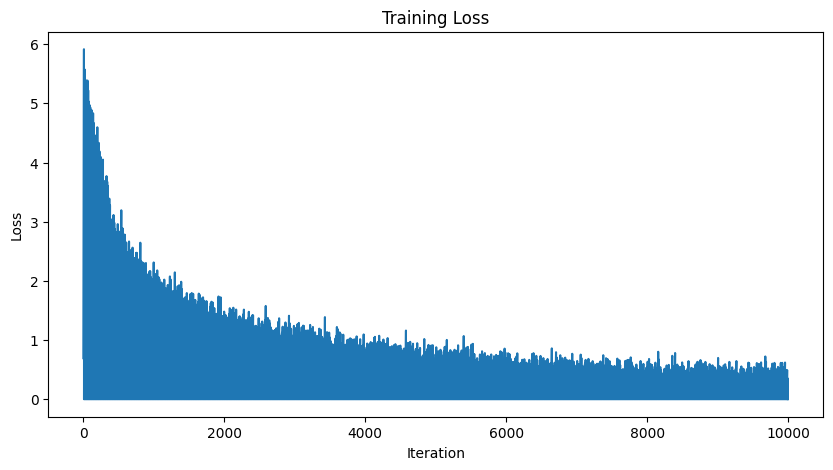

In [ ]:
import torch
import pickle
import torchvision
from torchvision import transforms
import torchvision.datasets as dset
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import time
import numpy as np
from collections import deque
import os
from tqdm.notebook import tqdm
from torch.optim import Adam
from torch.optim.lr_scheduler import LambdaLR
import numpy as np

# Initialize scheduler before training loop
scheduler = SiameseLearningScheduler(
    initial_lr=1e-3,
    initial_momentum=0.5,
    max_epochs=200,
    patience=20
)


# Configuration
class Config:
    cuda = torch.cuda.is_available()
    train_path = "/content/images_background"
    test_path = "/content/images_evaluation"
    way = 20
    times = 400
    workers = 12
    batch_size = 128
    lr = 0.0006
    show_every = 10
    save_every = 100
    test_every = 100
    max_iter = 50000
    model_path = "models"
    lr_min = 0.00001  # Minimum learning rate
    lr_scheduler = 'cosine' # Type of scheduler to use

# Create model directory
os.makedirs(Config.model_path, exist_ok=True)

# Setup device
device = torch.device('cuda' if Config.cuda else 'cpu')
print(f"Using device: {device}")

# Data transforms
data_transforms = transforms.Compose([
    transforms.RandomAffine(15),
    transforms.ToTensor()
])

# Setup datasets and loaders
trainSet = OmniglotTrain(Config.train_path, transform=data_transforms)
testSet = OmniglotTest(Config.test_path, transform=transforms.ToTensor(),
                       times=Config.times, way=Config.way)

trainLoader = DataLoader(trainSet, batch_size=Config.batch_size,
                        shuffle=False, num_workers=Config.workers)
testLoader = DataLoader(testSet, batch_size=Config.way,
                       shuffle=False, num_workers=Config.workers)

# Initialize model
net = Siamese()
if Config.cuda:
    net = net.cuda()
net.train()

# Loss and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=Config.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=Config.max_iter, eta_min=0)

# Training loop
train_loss = []
loss_val = 0
time_start = time.time()
queue = deque(maxlen=20)

progress_bar = tqdm(enumerate(trainLoader, 1), total=Config.max_iter)
for batch_id, (img1, img2, label) in progress_bar:
    if batch_id > Config.max_iter:
        break

    # Move to device
    img1, img2, label = img1.to(device), img2.to(device), label.to(device)

    # Forward pass
    optimizer.zero_grad()
    output = net(img1, img2)
    loss = loss_fn(output, label)
    loss_val += loss.item()

    # Backward pass
    loss.backward()
    optimizer.step()

    # Step the scheduler
    scheduler.step()

    # Get current learning rate
    current_lr = scheduler.get_last_lr()[0]

    # Update progress bar to show current learning rate
    progress_bar.set_description(f"Loss: {loss_val/(batch_id%Config.show_every + 1):.5f} LR: {current_lr:.6f}")

    # Update progress
    # progress_bar.set_description(f"Loss: {loss_val/(batch_id%Config.show_every + 1):.5f}")

    if batch_id % Config.show_every == 0:
        print(f'[{batch_id}]\tloss:\t{loss_val/Config.show_every:.5f}\t'
              f'time lapsed:\t{time.time() - time_start:.2f} s')
        loss_val = 0
        time_start = time.time()

    if batch_id % Config.save_every == 0:
        torch.save(net.state_dict(),
                  f'{Config.model_path}/model-inter-{batch_id+1}.pt')

    if batch_id % Config.test_every == 0:
        net.eval()
        right, error = 0, 0
        with torch.no_grad():
            for _, (test1, test2) in enumerate(testLoader, 1):
                test1, test2 = test1.to(device), test2.to(device)
                output = net(test1, test2).cpu().numpy()
                pred = np.argmax(output)
                if pred == 0:
                    right += 1
                else:
                    error += 1

        print('*'*70)
        precision = right*1.0/(right+error)
        print(f'[{batch_id}]\tTest set\tcorrect:\t{right}\terror:\t{error}\t'
              f'precision:\t{precision}')
        print('*'*70)
        queue.append(precision)
        net.train()

    train_loss.append(loss_val)

# Save training loss
with open('train_loss.pkl', 'wb') as f:
    pickle.dump(train_loss, f)

# Final accuracy
acc = sum(queue)/len(queue)
print("#"*70)
print(f"Final accuracy: {acc:.4f}")

# Plot training loss
plt.figure(figsize=(10,5))
plt.plot(train_loss)
plt.title('Training Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()